<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/EEG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [4]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_all.csv'),
    index_col=None
)

## Preprocessing

In [5]:
eeg.columns

Index(['Unnamed: 0', 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

In [6]:
eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [7]:
eeg.isnull().sum()

Trial                       0
Subject                     0
Block                       0
ProbeType                   0
ProbeTypeName               0
StimulusCategory            0
ListenCue                   0
ReactionTime              100
KeyCode                     0
Response                    0
ResponseCorrect             0
Omission                    0
StimulusAudioStart          0
StimulusAlignedTrigger      0
DelayPeriodOnset            0
MaintenancePeriodOnset      0
ProbeCueOnset               0
ProbeAudioStart             0
ProbeAlignedTrigger         0
TriggerValueCondition       0
StimulusSounds_idx          0
StimulusSounds_name         0
ProbeCategory               0
ProbeSound_idx              0
ProbeSound_name             0
dtype: int64

In [8]:
eeg.head()

,Trial,Subject,Block,ProbeType,ProbeTypeName,StimulusCategory,ListenCue,ReactionTime,KeyCode,Response,...,MaintenancePeriodOnset,ProbeCueOnset,ProbeAudioStart,ProbeAlignedTrigger,TriggerValueCondition,StimulusSounds_idx,StimulusSounds_name,ProbeCategory,ProbeSound_idx,ProbeSound_name
0,0,E2,1,1,out_of_sequence,High Words,5404.814769,NaN,2.Left3.Left,No Response,...,5411.364574,5413.680791,5414.747383,5414.747408,101,"[6, 7, 8, 4, 10]","[array(['mon.wav'], dtype='<U7'), array(['pcn....",Low Words,21,Sur.wav
1,1,E2,1,2,in_sequence,Low Non-words,5418.047203,1.282162,2.Left,Yes,...,5424.596991,5426.929894,5427.996527,5427.996549,104,"[39, 32, 35, 37, 38]","[array(['yuf.wav'], dtype='<U7'), array(['JcG....",Low Non-words,38,ycG.wav
2,2,E2,1,2,in_sequence,Low Words,5431.062824,0.987854,2.Left,Yes,...,5441.612599,5443.962166,5445.028782,5445.028767,103,[[27 23 22 24 25 29 26 28 30]],"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",Low Words,30,yuT.wav
3,3,E2,1,2,in_sequence,High Words,5447.795252,1.588743,2.Left,Yes,...,5454.344797,5456.677918,5457.744597,5457.744578,101,"[2, 5, 8, 4, 6]","[array(['fEl.wav'], dtype='<U7'), array(['lEr....",High Words,5,lEr.wav
4,4,E2,1,1,out_of_sequence,Low Non-words,5461.111022,1.184043,3.Left,No,...,5469.660532,5472.110369,5473.176951,5473.176957,104,[[34 35 36 40 39 33 37]],"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",High Non-Words,13,g@n.wav


In [9]:
eeg.shape

(5568, 25)

In [10]:
eeg_subset = eeg[[
                 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
                 'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
                 'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
                  'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx'                 
]]

In [11]:
eeg_subset.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx
0,0,E2,1,1,21,out_of_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,Low Words,"[array(['mon.wav'], dtype='<U7'), array(['pcn....",Sur.wav,"[6, 7, 8, 4, 10]"
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]"
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,[[27 23 22 24 25 29 26 28 30]]
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]"
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,[[34 35 36 40 39 33 37]]


In [12]:
eeg_subset[eeg_subset['Response'] == 'No Response']

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx
0,0,E2,1,1,21,out_of_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,Low Words,"[array(['mon.wav'], dtype='<U7'), array(['pcn....",Sur.wav,"[6, 7, 8, 4, 10]"
63,63,E2,2,2,11,in_sequence,High Non-Words,NaN,2.Left3.Left,No Response,0,No Response,High Non-Words,"[[array(['kEl.wav'], dtype='<U7')]\n [array(['...",Rin.wav,[[14 11 17]]
74,74,E2,3,2,6,in_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,High Words,"[[array(['wIC.wav'], dtype='<U7')]\n [array(['...",mon.wav,[[10 6 9]]
298,106,E3,4,1,11,out_of_sequence,High Non-Words,NaN,2.Left3.Left,No Response,0,No Response,High Non-Words,"[[array(['pun.wav'], dtype='<U7')]\n [array(['...",Rin.wav,[[18 20 14]]
310,118,E3,4,1,6,out_of_sequence,Low Words,NaN,2.Left3.Left,No Response,0,No Response,High Words,"[[array(['Sur.wav'], dtype='<U7')]\n [array(['...",mon.wav,[[21 27 24 22 30 26 28 23 29]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5064,72,E30,3,1,33,out_of_sequence,High Non-Words,NaN,2.Left3.Left,No Response,0,No Response,Low Non-Words,"[[array(['paon.wav'], dtype='<U8')]\n [array([...",gawth.wav,[[16 12 15 19 13 17 20]]
5131,139,E30,5,1,16,out_of_sequence,High Non-Words,NaN,2.Left3.Left,No Response,0,No Response,High Non-Words,"[[array(['rihn.wav'], dtype='<U8')]\n [array([...",paon.wav,[[19 15 18 11 13 14 12 17 20]]
5159,167,E30,6,1,37,out_of_sequence,High Non-Words,NaN,2.Left3.Left,No Response,0,No Response,Low Non-Words,"[array(['rehl.wav'], dtype='<U8'), array(['sao...",wehz.wav,"[18, 20, 16, 19, 17]"
5332,148,E31,5,1,19,out_of_sequence,Low Non-words,NaN,2.Left3.Left,No Response,0,No Response,High Non-Words,"[[array(['kuv.wav'], dtype='<U7')]\n [array(['...",rihn.wav,[[35 32 40 34 38 39 37 33 31]]


In [13]:
# deleting all the trials with no responses
eeg_clean = eeg_subset[eeg_subset['Response'] != 'No Response']

In [14]:
eeg_clean.isnull().sum()

Trial                  0
Subject                0
Block                  0
ProbeType              0
ProbeSound_idx         0
ProbeTypeName          0
StimulusCategory       0
ReactionTime           0
KeyCode                0
Response               0
ResponseCorrect        0
Omission               0
ProbeCategory          0
StimulusSounds_name    0
ProbeSound_name        0
StimulusSounds_idx     0
dtype: int64

In [15]:
# creating CorrPercentage variable
eeg_clean['CorrPercentage'] = np.nan
subjects = eeg_clean['Subject'].unique().tolist()
length = eeg_clean.groupby(['Subject'])['Trial'].count() # number of trials per subject
correct = eeg_clean.groupby(['Subject'])['ResponseCorrect'].sum() # sum of correct answers per subject
for subj in subjects:
  value = correct[subj] / length[subj]
  eeg_clean.loc[eeg_clean['Subject'] == subj, 'CorrPercentage'] = value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
# check if any of the subject is less than 75 % accurate
(eeg_clean.groupby(['Subject'])['CorrPercentage'].first() < 0.75).any()

False

In [17]:
# stndardize reaction time with no regard to the subject
rt = eeg_clean['ReactionTime'].values
eeg_clean['stdRT'] = (rt - rt.mean())/rt.std()
# standardization = lambda x: (x - x.mean()) / x.std()
# lcvs_standard = lcvs.groupby(["object_id", "passband"])[["flux"]].transform(standardization)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x720 with 0 Axes>

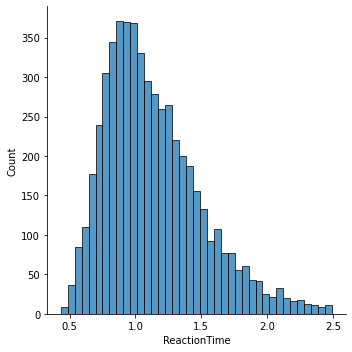

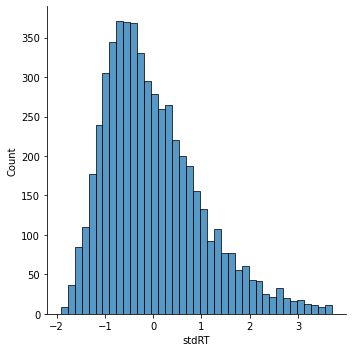

In [18]:
pl.figure(figsize = (20, 10))
seaborn.displot(eeg_clean['ReactionTime'])
seaborn.displot(eeg_clean['stdRT']);

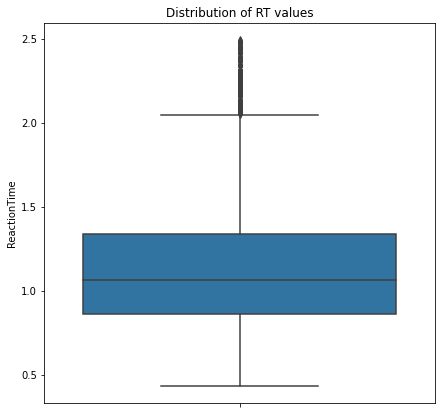

In [19]:
pl.figure(figsize = (7, 7))
ax = seaborn.boxplot(y="ReactionTime", data=eeg_clean)
pl.title("Distribution of RT values");

In [26]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end

# making values in df more 'handy'
whole_list = eeg_clean['StimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  new_sound_idx.append(
      [int(s) for s in re.findall(r'\b\d+\b', i)]
  )
eeg_clean['StimulusSounds_idx'] = new_sound_idx # substitute string type to list with numbers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [33]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[5, 9, 7, 3]


In [46]:
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_clean['ProbeSound_idx'].values
in_out = eeg_clean['ProbeTypeName'].values
for i in range(0, len(ind)):
  if in_out[i] == 'in_sequence': # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 'out_of_sequence':
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [153]:
length = []
for i in eeg_clean.StimulusSounds_idx:
  length.append(len(i))

[5, 9, 5, 7, 9, 3, 7, 7, 7, 5, 9, 9, 9, 9, 3, 3, 7, 3, 9, 5, 7, 7, 3, 3, 7, 5, 3, 9, 3, 5, 5, 9, 3, 7, 5, 7, 7, 5, 5, 3, 7, 9, 7, 9, 7, 3, 3, 5, 9, 7, 5, 5, 3, 3, 7, 9, 9, 3, 9, 9, 5, 5, 3, 3, 9, 7, 7, 3, 7, 5, 7, 3, 3, 7, 9, 9, 7, 3, 9, 7, 5, 7, 5, 9, 9, 3, 5, 5, 9, 9, 5, 5, 5, 7, 9, 3, 3, 9, 5, 9, 7, 5, 5, 3, 7, 5, 7, 3, 3, 7, 7, 5, 3, 5, 7, 9, 5, 9, 3, 7, 9, 9, 3, 9, 5, 5, 5, 7, 9, 5, 7, 3, 9, 5, 7, 9, 9, 3, 9, 3, 5, 3, 7, 5, 5, 9, 5, 7, 7, 7, 3, 3, 9, 9, 3, 3, 7, 7, 3, 7, 7, 9, 5, 9, 5, 5, 9, 7, 7, 5, 3, 9, 5, 5, 3, 5, 7, 7, 9, 9, 9, 9, 3, 5, 3, 7, 3, 3, 3, 5, 5, 9, 5, 7, 9, 3, 7, 7, 7, 5, 9, 9, 9, 9, 3, 3, 7, 3, 9, 5, 7, 7, 3, 3, 7, 5, 3, 9, 3, 5, 5, 9, 3, 7, 5, 7, 7, 5, 5, 3, 7, 9, 7, 9, 7, 3, 3, 5, 9, 7, 5, 5, 3, 3, 7, 9, 9, 3, 9, 9, 5, 5, 3, 3, 3, 9, 7, 7, 3, 7, 5, 7, 3, 3, 3, 7, 9, 9, 7, 3, 9, 7, 5, 7, 5, 9, 9, 3, 5, 5, 9, 9, 5, 5, 5, 7, 9, 3, 3, 9, 5, 9, 7, 5, 5, 7, 5, 7, 3, 3, 7, 7, 5, 3, 5, 7, 5, 9, 3, 7, 9, 9, 3, 9, 5, 5, 5, 7, 9, 5, 7, 3, 9, 5, 7, 9, 9, 3, 9, 3, 5, 3, 7, 

In [156]:
eeg_clean['Position'] = positions
eeg_clean['Length'] = length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [296]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in eeg_clean.ProbeCategory.values:
  new_probe.append(i.lower())
eeg_clean['ProbeCategory'] = new_probe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [297]:
eeg_clean

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,stdRT,Position,Length
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.888889,0.401952,3,5
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.888889,-0.401598,3,9
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.888889,1.239013,1,5
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.888889,0.134058,0,7
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,1,Responded,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.888889,1.177841,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,187,E33,6,2,5,in_sequence,High Words,0.675257,2.Left,Yes,1,Responded,high words,"[[array(['debt.wav'], dtype='<U8')]\n [array([...",lair.wav,"[2, 8, 7, 6, 9, 5, 1]",0.958115,-1.255086,3,7
5564,188,E33,6,2,40,in_sequence,Low Non-words,1.023468,2.Left,Yes,1,Responded,low non-words,"[[array(['deech.wav'], dtype='<U9')]\n [array(...",zerth.wav,"[31, 39, 32, 35, 40, 36, 33, 34, 37]",0.958115,-0.304362,2,9
5565,189,E33,6,2,31,in_sequence,Low Non-words,1.132745,2.Left,Yes,1,Responded,low non-words,"[[array(['deech.wav'], dtype='<U9')]\n [array(...",deech.wav,"[31, 36, 33, 37, 35, 34, 32, 40, 38]",0.958115,-0.006003,1,9
5566,190,E33,6,2,19,in_sequence,High Non-Words,0.676137,2.Left,Yes,1,Responded,high non-words,"[[array(['rehl.wav'], dtype='<U8')]\n [array([...",rihn.wav,"[18, 19, 13]",0.958115,-1.252682,2,3


In [298]:
# check for outliers outside 
eeg_no_outliers = eeg_clean.copy()
q75 = np.percentile(eeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(eeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
for value in eeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
  elif value > upper:
    col_new.append(np.nan)
  else:
    col_new.append(value)
eeg_no_outliers['ReactionTime'] = col_new

In [299]:
print(eeg_no_outliers.isnull().sum()['ReactionTime'])
# drop outliers
eeg_no_outliers = eeg_no_outliers.dropna()
print(eeg_no_outliers.isnull().sum()['ReactionTime'])

134
0


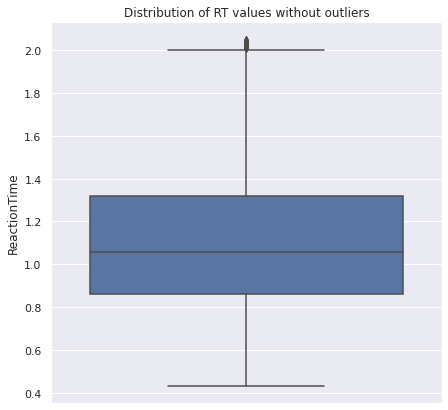

In [300]:
pl.figure(figsize = (7, 7))
ax = seaborn.boxplot(y="ReactionTime", data=eeg_no_outliers)
pl.title("Distribution of RT values without outliers");

<Figure size 1440x720 with 0 Axes>

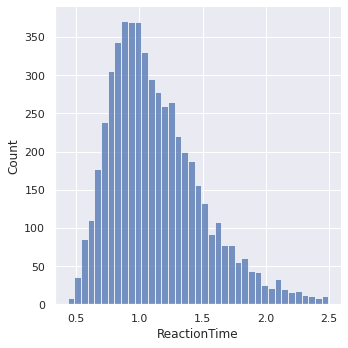

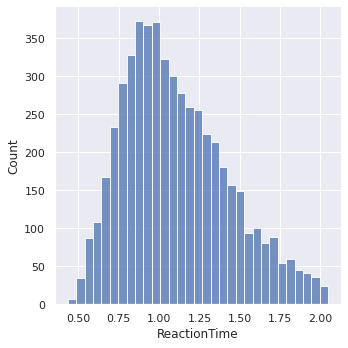

In [301]:
# upper plot - with outliers, lower plot - without
pl.figure(figsize = (20, 10))
seaborn.displot(eeg_clean['ReactionTime'])
seaborn.displot(eeg_no_outliers['ReactionTime']);

There are two datasets now: eeg_clean - with outliers in RT, eeg_no_outliers - without

## Plotting the accuracy across conditions

In [234]:
eeg_clean.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,stdRT,Position,Length
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.888889,0.401952,3,5
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.888889,-0.401598,3,9
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.888889,1.239013,1,5
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.888889,0.134058,0,7
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,1,Responded,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.888889,1.177841,1,9


In [159]:
seaborn.set()

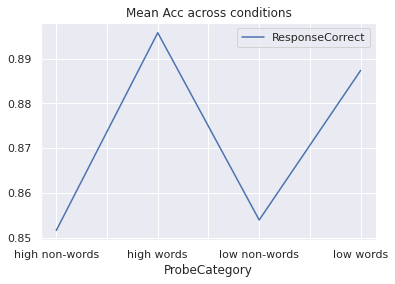

In [236]:
eeg_clean.groupby(['ProbeCategory'])['ResponseCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across conditions'
    );

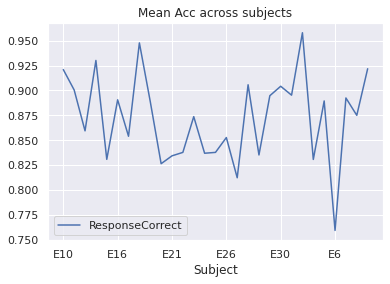

In [237]:
eeg_clean.groupby(['Subject'])['ResponseCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across subjects'
    );

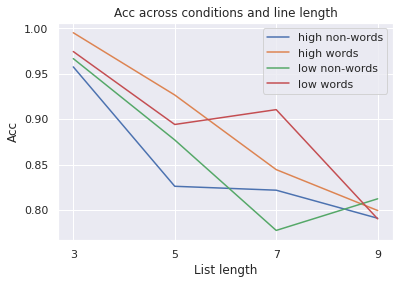

In [306]:
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
acc_count = lambda v: sum(v) / v.count()
pl.figure()
subset = eeg_clean.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].apply(
    acc_count
).reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length');  

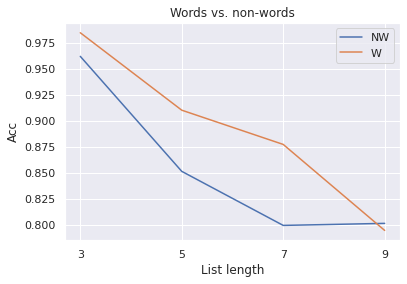

In [307]:
words_nonwords = subset.copy()
new_names = [] 
names = words_nonwords.ProbeCategory.values
for i in names:
  if 'non-words' in i:
    new_names.append('NW')
  elif 'words' in i:
    new_names.append('W')
  else:
    print('Check', i)
    break
words_nonwords['ProbeCategory'] = new_names

pl.figure()
words_nonwords = words_nonwords.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].apply(
    acc_count
). reset_index()
for i in words_nonwords.ProbeCategory.unique():
  x = words_nonwords[words_nonwords['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.ProbeCategory.unique())
pl.title('Words vs. non-words');  

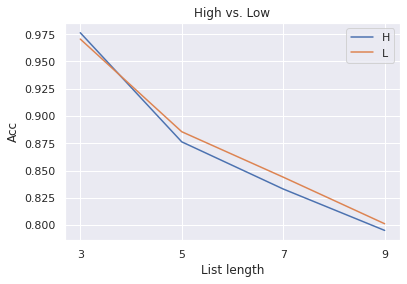

In [308]:
high_low = subset.copy()
new_names = [] 
names = high_low.ProbeCategory.values
for i in names:
  if 'low' in i:
    new_names.append('L')
  elif 'high' in i:
    new_names.append('H')
  else:
    print('Check', i)
    break
high_low['ProbeCategory'] = new_names

pl.figure()
high_low = high_low.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].apply(
    acc_count
). reset_index()
for i in high_low.ProbeCategory.unique():
  x = high_low[high_low['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.ProbeCategory.unique())
pl.title('High vs. Low');  

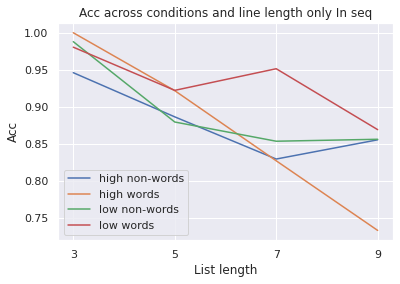

In [243]:
# plotting categories across condition when the probe is in sequence
subset = eeg_clean[eeg_clean['ProbeType'] == 2]
acc_count = lambda v: sum(v) / v.count()
pl.figure()
subset = subset.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].apply(
    acc_count
).reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only In seq');  

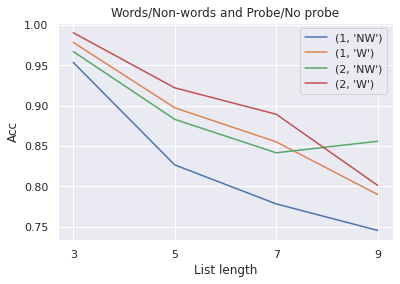

In [276]:
# probe type 2 = in seq, 1 = out of seq
subset = eeg_clean.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
probe_words = subset.copy()
new_cat = []
cat = probe_words.ProbeCategory.values
for i in cat:
  if 'non-words' in i:
    new_cat.append('NW')
  elif 'words' in i:
    new_cat.append('W')
  else:
    print("Check")
probe_words['ProbeCategory'] = new_cat

probe_words = probe_words.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.ProbeCategory.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['ProbeCategory'] == j)]
    pl.plot(x.Length, x.ResponseCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words/Non-words and Probe/No probe');

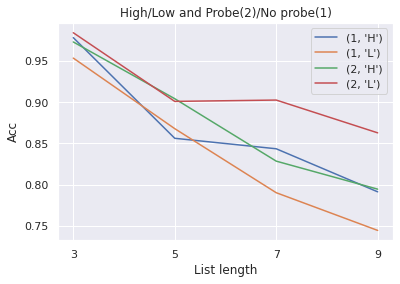

In [278]:
subset = eeg_clean.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
probe_words = subset.copy()
new_cat = []
cat = probe_words.ProbeCategory.values
for i in cat:
  if 'high' in i:
    new_cat.append('H')
  elif 'low' in i:
    new_cat.append('L')
  else:
    print("Check")
probe_words['ProbeCategory'] = new_cat

probe_words = probe_words.groupby(['ProbeType', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.ProbeCategory.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['ProbeCategory'] == j)]
    pl.plot(x.Length, x.ResponseCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High/Low and Probe(2)/No probe(1)');

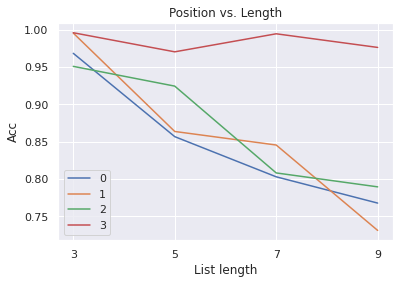

In [285]:
subset = eeg_clean.groupby(['Position', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length');

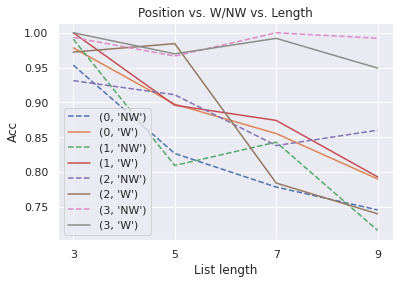

In [295]:
subset = eeg_clean.groupby(['Position', 'Length', 'ProbeCategory'])[['ResponseCorrect']].mean().reset_index()
pos_words = subset.copy()
new_cat = []
cat = pos_words.ProbeCategory.values
for i in cat:
  if 'non-words' in i:
    new_cat.append('NW')
  elif 'words' in i:
    new_cat.append('W')
  else:
    print("Check")
pos_words['ProbeCategory'] = new_cat

pos_words = pos_words.groupby(['Position', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()

for i in pos_words.Position.unique():
  for j in pos_words.ProbeCategory.unique():
    x = pos_words[(pos_words['Position'] == i) & (pos_words['ProbeCategory'] == j)]
    if j == 'NW':
      pl.plot(x.Length, x.ResponseCorrect, '--', label = (i, j))
    elif j == 'W':
      pl.plot(x.Length, x.ResponseCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Position vs. W/NW vs. Length');

## Plotting the RT across conditions

In [302]:
eeg_no_outliers.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,stdRT,Position,Length
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.888889,0.401952,3,5
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.888889,-0.401598,3,9
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.888889,1.239013,1,5
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.888889,0.134058,0,7
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,1,Responded,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.888889,1.177841,1,9


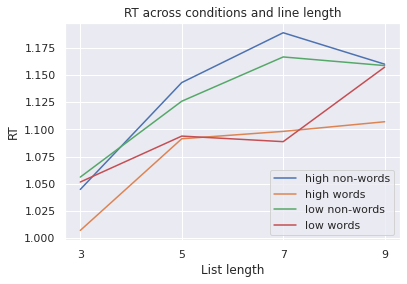

In [309]:
subset = eeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length');  

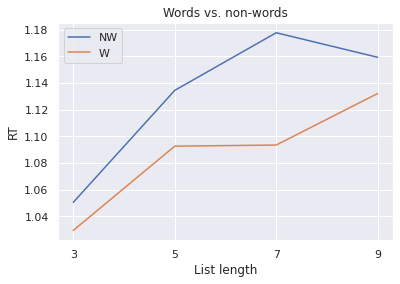

In [311]:
words_nonwords = subset.copy()
new_names = [] 
names = words_nonwords.ProbeCategory.values
for i in names:
  if 'non-words' in i:
    new_names.append('NW')
  elif 'words' in i:
    new_names.append('W')
  else:
    print('Check', i)
    break
words_nonwords['ProbeCategory'] = new_names

pl.figure()
words_nonwords = words_nonwords.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in words_nonwords.ProbeCategory.unique():
  x = words_nonwords[words_nonwords['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.ProbeCategory.unique())
pl.title('Words vs. non-words');  

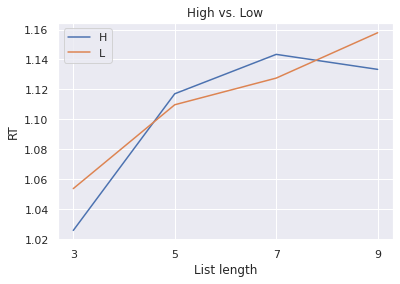

In [313]:
high_low = subset.copy()
new_names = [] 
names = high_low.ProbeCategory.values
for i in names:
  if 'low' in i:
    new_names.append('L')
  elif 'high' in i:
    new_names.append('H')
  else:
    print('Check', i)
    break
high_low['ProbeCategory'] = new_names

pl.figure()
high_low = high_low.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in high_low.ProbeCategory.unique():
  x = high_low[high_low['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.ProbeCategory.unique())
pl.title('High vs. Low');  

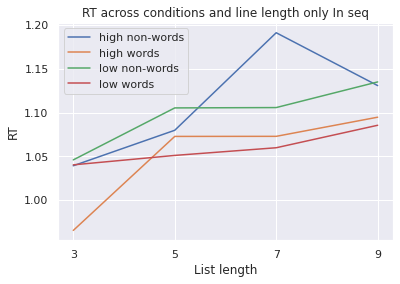

In [314]:
# plotting categories across condition when the probe is in sequence
subset = eeg_no_outliers[eeg_no_outliers['ProbeType'] == 2]
pl.figure()
subset = subset.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only In seq');